c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                                text     label
0  ডিরেক্টলি গেলে প্লেনে যেতে হবে । সেই ক্ষেত্রে ...   neutral
1         অন্তিম অবতারের পিতার নাম হবে ' বিষ্ণু যশা    neutral
2                    দাদা বোগরাতে এমন খাবার কথাই পাব   neutral
3  কোরবানি ঈদের সাথে মিল রেখে এক্সট্রা অর্ডিনারী ...   neutral
4                           আপনার মতো একজন বুদ্ধিমান  positive


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 4946/4946 [00:00<00:00, 20566.78 examples/s]
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_14712\1586105761.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.690500,0.770145,0.693288,0.688392
2,0.720500,0.668638,0.732915,0.730086
3,0.560100,0.695502,0.746057,0.743184



 Evaluation results: {'eval_loss': 0.6955022215843201, 'eval_accuracy': 0.7460574201374849, 'eval_f1': 0.7431839795565458, 'eval_runtime': 23.1194, 'eval_samples_per_second': 213.933, 'eval_steps_per_second': 53.505, 'epoch': 3.0}
 Classification Report:
               precision    recall  f1-score   support

    negative       0.74      0.79      0.76      1648
     neutral       0.69      0.59      0.64      1387
    positive       0.78      0.82      0.80      1911

    accuracy                           0.75      4946
   macro avg       0.74      0.73      0.73      4946
weighted avg       0.74      0.75      0.74      4946



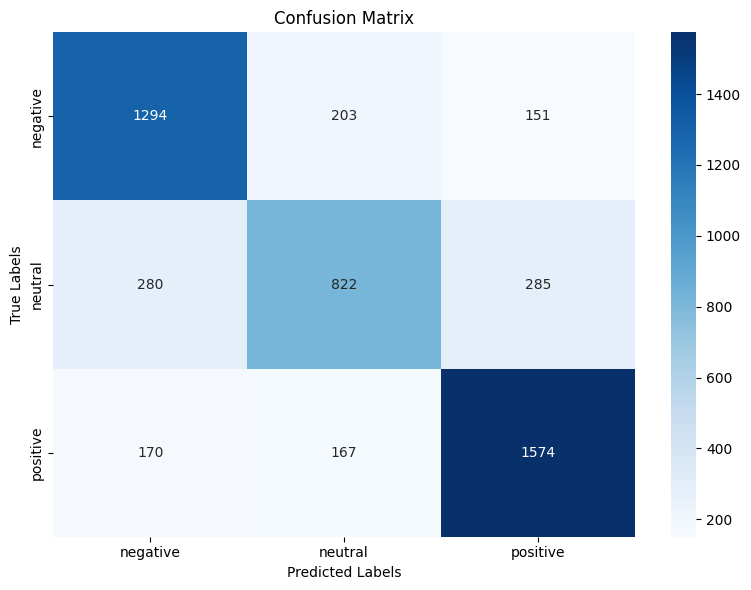

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
import torch
import numpy as np
import os

# Load dataset
df = pd.read_csv('3c_sentiment.csv')
df = df.dropna()
data = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(data.head())
X = data['text']
y = data['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.astype(str))

# Create Hugging Face dataset
dataset = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Load BanglaBERT tokenizer and model
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label_encoder.classes_)
)

# Tokenize
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=128)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    report_to=[]
)

# Metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

# Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(f"\n Evaluation results: {eval_results}")

# Predictions
predictions_output = trainer.predict(dataset['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [str(label_encoder.classes_[i]) for i in used_labels]

report = classification_report(
    labels, predictions,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
)
print(" Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                                text     label
0  ডিরেক্টলি গেলে প্লেনে যেতে হবে । সেই ক্ষেত্রে ...   neutral
1         অন্তিম অবতারের পিতার নাম হবে ' বিষ্ণু যশা    neutral
2                    দাদা বোগরাতে এমন খাবার কথাই পাব   neutral
3  কোরবানি ঈদের সাথে মিল রেখে এক্সট্রা অর্ডিনারী ...   neutral
4                           আপনার মতো একজন বুদ্ধিমান  positive


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 4946/4946 [00:00<00:00, 16839.64 examples/s]
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_9524\2740744587.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.746800,0.742280,0.692074,0.685313
2,0.653600,0.654966,0.731298,0.729056
3,0.518800,0.687843,0.745855,0.742485



 Evaluation results: {'eval_loss': 0.687843382358551, 'eval_accuracy': 0.7458552365547918, 'eval_f1': 0.7424849739158422, 'eval_runtime': 36.4101, 'eval_samples_per_second': 135.841, 'eval_steps_per_second': 33.974, 'epoch': 3.0}
 Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.79      0.77      1648
     neutral       0.69      0.58      0.63      1387
    positive       0.77      0.83      0.80      1911

    accuracy                           0.75      4946
   macro avg       0.74      0.73      0.73      4946
weighted avg       0.74      0.75      0.74      4946



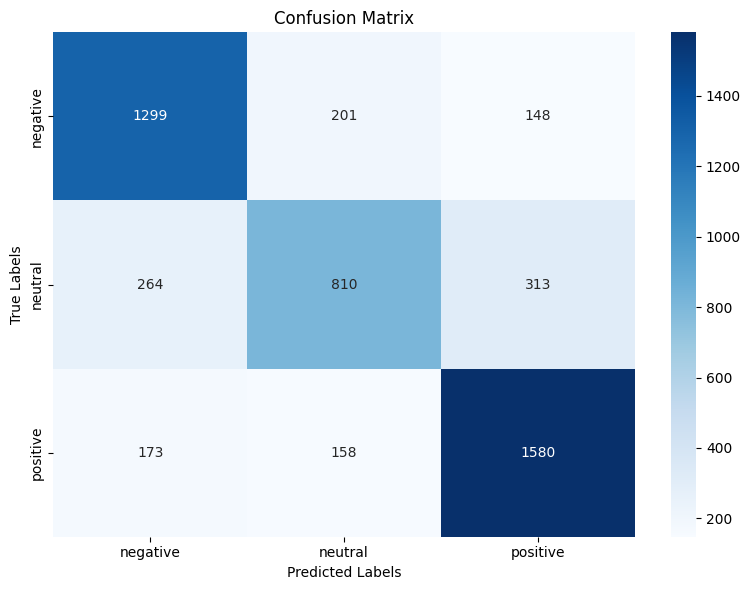

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
import torch
import numpy as np
import os

# Load dataset
df = pd.read_csv('3c_sentiment.csv')
df = df.dropna()
data = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(data.head())
X = data['text']
y = data['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.astype(str))

# Create Hugging Face dataset
dataset = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Load BanglaBERT tokenizer and model
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label_encoder.classes_)
)

# Tokenize
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=128)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    report_to=[]
)

# Metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

# Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(f"\n Evaluation results: {eval_results}")

# Predictions
predictions_output = trainer.predict(dataset['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [str(label_encoder.classes_[i]) for i in used_labels]

report = classification_report(
    labels, predictions,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
)
print(" Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 4946/4946 [00:00<00:00, 20584.73 examples/s]
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_13512\590878428.py:91: Futur

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.669900,0.679865,0.715932,0.711294
2,0.612200,0.650884,0.735140,0.734816
3,0.545300,0.633398,0.750303,0.744532
4,0.384600,0.734934,0.752123,0.750674



 Evaluation results: {'eval_loss': 0.7349341511726379, 'eval_accuracy': 0.7521229276182774, 'eval_f1': 0.7506740381996531, 'eval_runtime': 8.9704, 'eval_samples_per_second': 551.369, 'eval_steps_per_second': 69.005, 'epoch': 4.996360695511525}
 Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.78      0.77      1648
     neutral       0.67      0.63      0.65      1387
    positive       0.79      0.82      0.80      1911

    accuracy                           0.75      4946
   macro avg       0.74      0.74      0.74      4946
weighted avg       0.75      0.75      0.75      4946



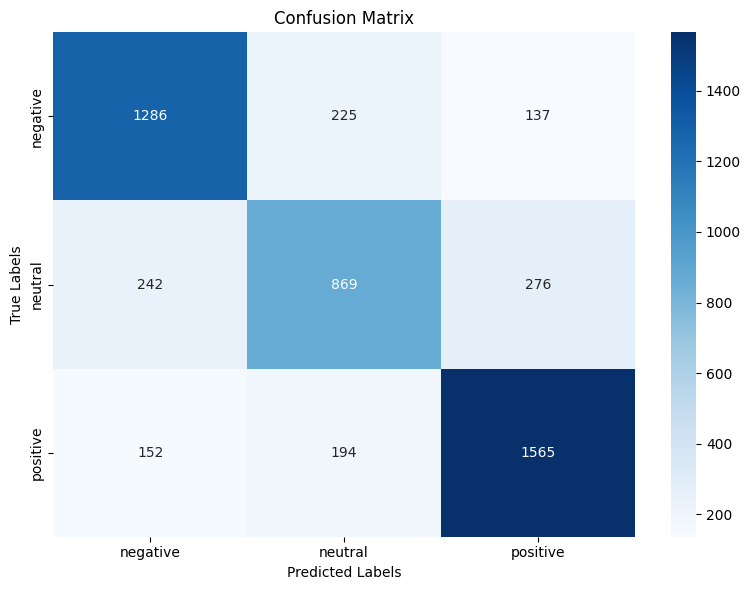

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
import torch
import numpy as np
import os
import random

# Fix random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

# Load dataset
df = pd.read_csv('3c_sentiment.csv')
df = df.dropna()
data = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = data['text']
y = data['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.astype(str))

# Create Hugging Face dataset
dataset = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
dataset = dataset.train_test_split(test_size=0.2, seed=42)


model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label_encoder.classes_)
)

# Tokenize
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=128)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    fp16=True,  # Mixed precision
    gradient_checkpointing=True,
    seed=42,
    report_to=[]
)

# Metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

# Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(f"\n Evaluation results: {eval_results}")

# Predictions
predictions_output = trainer.predict(dataset['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [str(label_encoder.classes_[i]) for i in used_labels]

report = classification_report(
    labels, predictions,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
)
print(" Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 4946/4946 [00:00<00:00, 15254.73 examples/s]
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_13512\3343978583.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.992600,0.999174,0.524262,0.494562
2,0.886500,0.883735,0.639102,0.627858
3,0.804600,0.886817,0.662556,0.653402
4,0.747000,0.829310,0.675091,0.662974
5,0.727600,0.829998,0.696725,0.692984



Evaluation Results:
{'eval_loss': 0.8299981355667114, 'eval_accuracy': 0.696724625960372, 'eval_f1': 0.6929843517602012, 'eval_runtime': 15.2239, 'eval_samples_per_second': 324.884, 'eval_steps_per_second': 40.66, 'epoch': 5.995551961180752}
Classification Report:
               precision    recall  f1-score   support

    negative       0.72      0.71      0.71      1742
     neutral       0.62      0.53      0.57      1322
    positive       0.72      0.80      0.76      1882

    accuracy                           0.70      4946
   macro avg       0.69      0.68      0.68      4946
weighted avg       0.69      0.70      0.69      4946



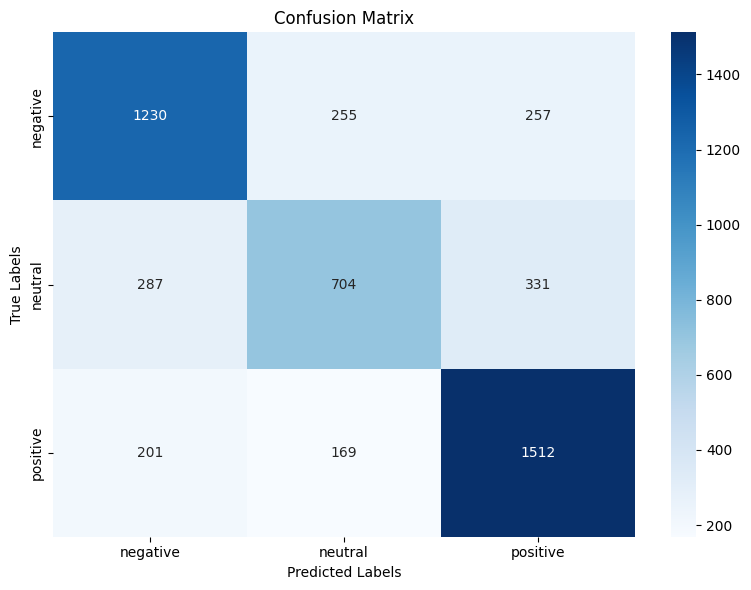

In [2]:
import pandas as pd
import numpy as np
import torch
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from datasets import Dataset

# 1. Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

# 2. Load and preprocess dataset
df = pd.read_csv('3c_sentiment.csv').dropna()
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df['text']
y = df['label']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.astype(str))
num_labels = len(label_encoder.classes_)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Create Dataset object
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'label': y_train}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test, 'label': y_test}))
dataset = {"train": train_dataset, "test": test_dataset}

# 3. Load XLM-RoBERTa
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    hidden_dropout_prob=0.3,   # Extra dropout
    attention_probs_dropout_prob=0.3
)

# 4. Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=256)

dataset['train'] = dataset['train'].map(tokenize_function, batched=True)
dataset['test'] = dataset['test'].map(tokenize_function, batched=True)
for split in dataset:
    dataset[split] = dataset[split].remove_columns(['text']).rename_column('label', 'labels')
    dataset[split].set_format('torch')

# 5. Metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

# 6. Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    fp16=True,
    gradient_checkpointing=True,
    seed=42,
    report_to=[]
)

# 7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# 8. Train
trainer.train()

# 9. Evaluate
eval_results = trainer.evaluate()
print(f"\nEvaluation Results:\n{eval_results}")

# 10. Predict
predictions_output = trainer.predict(dataset['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# 11. Classification Report
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [str(label_encoder.classes_[i]) for i in used_labels]

report = classification_report(
    labels, predictions,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
)
print("Classification Report:\n", report)

# 12. Confusion Matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
import numpy as np
import torch
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from datasets import Dataset

# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

# Load and preprocess
df = pd.read_csv('3c_sentiment.csv').dropna().sample(frac=1, random_state=42)
X, y = df['text'], df['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.astype(str))
num_labels = len(label_encoder.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'label': y_train}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test, 'label': y_test}))

# Tokenizer and model
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(['text']).rename_column('label', 'labels')
test_dataset = test_dataset.remove_columns(['text']).rename_column('label', 'labels')
train_dataset.set_format('torch')
test_dataset.set_format('torch')

# Metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

# Model init
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Base args (fixed values)
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    report_to=[]
)

# Trainer (initialization for tuning)
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Hyperparameter search using Optuna
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_categorical("learning_rate", [2e-5, 3e-5, 5e-5]),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 5),
        "weight_decay": trial.suggest_categorical("weight_decay", [0.0, 0.01, 0.1]),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.3),
        "gradient_accumulation_steps": trial.suggest_int("gradient_accumulation_steps", 1, 2),
        "seed": trial.suggest_int("seed", 42, 42)  # fixed
    }

best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    n_trials=10,
    hp_space=optuna_hp_space
)

print("✅ Best hyperparameters found:\n", best_run.hyperparameters)

# Update training args
best_args = training_args
for k, v in best_run.hyperparameters.items():
    setattr(best_args, k, v)

# Final trainer with early stopping
final_trainer = Trainer(
    model_init=model_init,
    tokenizer=tokenizer,
    args=best_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
final_trainer.train()

# Evaluate
eval_results = final_trainer.evaluate()
print("✅ Final Evaluation Results:", eval_results)

# Predictions
predictions_output = final_trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [str(label_encoder.classes_[i]) for i in used_labels]

print("✅ Classification Report:\n", classification_report(
    labels, predictions, labels=used_labels, target_names=used_class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


Map: 100%|██████████| 4946/4946 [00:00<00:00, 10172.95 examples/s]
C:\Users\User\AppData\Local\Temp\ipykernel_2096\2775155559.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-07-20 01:33:39,057] A new study created in memory with name: no-name-2c1ae930-a007-4923-969a-1ada6ebb66a2
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'cl

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.795900,0.716646,0.704812,0.706020
2,0.651300,0.628039,0.741609,0.736039
3,0.520500,0.632978,0.760210,0.761301
4,0.419100,0.691003,0.763647,0.762057


[I 2025-07-20 02:22:38,316] Trial 0 finished with value: 1.5257042111314694 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.0, 'warmup_ratio': 0.10098986083947677, 'gradient_accumulation_steps': 2, 'seed': 42}. Best is trial 0 with value: 1.5257042111314694.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.094200,1.095536,0.380510,0.209759
2,1.095300,1.088462,0.380510,0.209759
3,1.097400,1.087898,0.380510,0.209759
4,1.093100,1.073734,0.380510,0.209759


[I 2025-07-20 03:19:28,743] Trial 1 finished with value: 0.5902689882600864 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.01, 'warmup_ratio': 0.02981849401507125, 'gradient_accumulation_steps': 1, 'seed': 42}. Best is trial 0 with value: 1.5257042111314694.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.781100,0.698120,0.701981,0.704339
2,0.671200,0.640937,0.738779,0.734517
3,0.550200,0.650268,0.749697,0.748526
4,0.448700,0.699345,0.751921,0.753817
5,0.342300,0.756253,0.756167,0.756297


[I 2025-07-20 05:26:17,083] Trial 2 finished with value: 1.5124631215591704 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.1, 'warmup_ratio': 0.030404494245241775, 'gradient_accumulation_steps': 2, 'seed': 42}. Best is trial 0 with value: 1.5257042111314694.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.829000,0.811518,0.684796,0.678988
2,0.672200,0.681458,0.735544,0.731048
3,0.538100,0.658819,0.753134,0.750792


[I 2025-07-20 06:09:38,474] Trial 3 finished with value: 1.5039259905886353 and parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.1, 'warmup_ratio': 0.2977696972923385, 'gradient_accumulation_steps': 1, 'seed': 42}. Best is trial 0 with value: 1.5257042111314694.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.892500,0.725670,0.691872,0.687366
2,0.730100,0.641424,0.737566,0.733541
3,0.618200,0.664775,0.747068,0.745465
4,0.534300,0.648640,0.752325,0.751961
5,0.332000,0.733185,0.758795,0.758705


[I 2025-07-20 07:48:41,873] Trial 4 finished with value: 1.5174999934287987 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_ratio': 0.2238376446966501, 'gradient_accumulation_steps': 2, 'seed': 42}. Best is trial 0 with value: 1.5257042111314694.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.821300,0.770139,0.686818,0.685697
2,0.875900,1.088060,0.380510,0.209759
3,1.100300,1.087987,0.380510,0.209759
4,1.094000,1.088108,0.380307,0.209679
5,1.088900,1.088152,0.380510,0.209759


[I 2025-07-20 09:00:47,328] Trial 5 finished with value: 0.5902689882600864 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_ratio': 0.2567036257801852, 'gradient_accumulation_steps': 1, 'seed': 42}. Best is trial 0 with value: 1.5257042111314694.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.792400,0.715455,0.704205,0.705185


[W 2025-07-20 09:13:09,726] Trial 6 failed with parameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.0, 'warmup_ratio': 0.17736626294869634, 'gradient_accumulation_steps': 2, 'seed': 42} because of the following error: RuntimeError('[enforce fail at inline_container.cc:626] . unexpected pos 1084218112 vs 1084218000').
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\llm\Lib\site-packages\torch\serialization.py", line 944, in save
    _save(
  File "c:\Users\User\anaconda3\envs\llm\Lib\site-packages\torch\serialization.py", line 1216, in _save
    zip_file.write_record(name, storage, num_bytes)
RuntimeError: [enforce fail at inline_container.cc:820] . PytorchStreamWriter failed writing file data/2: file write failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\llm\Lib\site-packages\optuna\study\_optimize.py", l

RuntimeError: [enforce fail at inline_container.cc:626] . unexpected pos 1084218112 vs 1084218000

In [3]:
import pandas as pd
import numpy as np
import torch
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from datasets import Dataset

# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

# Load and preprocess
df = pd.read_csv('3c_sentiment.csv').dropna().sample(frac=1, random_state=42)
X, y = df['text'], df['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.astype(str))
num_labels = len(label_encoder.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'label': y_train}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test, 'label': y_test}))

# Tokenizer and model
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(['text']).rename_column('label', 'labels')
test_dataset = test_dataset.remove_columns(['text']).rename_column('label', 'labels')
train_dataset.set_format('torch')
test_dataset.set_format('torch')

# Metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

# Model init
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Arguments for tuning (disable saving to avoid I/O crash)
tune_args = TrainingArguments(
    output_dir="./tmp_tune_output",
    eval_strategy="epoch",
    save_strategy="no",  # prevent writing to disk
    logging_strategy="no",
    report_to=[],
    load_best_model_at_end=False,
    disable_tqdm=True
)

# Trainer for tuning
tune_trainer = Trainer(
    model_init=model_init,
    args=tune_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Optuna hyperparameter search space
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_categorical("learning_rate", [2e-5, 3e-5, 5e-5]),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 5),
        "weight_decay": trial.suggest_categorical("weight_decay", [0.0, 0.01, 0.1]),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.3),
        "gradient_accumulation_steps": trial.suggest_int("gradient_accumulation_steps", 1, 2),
        "seed": trial.suggest_int("seed", 42, 42)  # fixed
    }

# Run search
best_run = tune_trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    n_trials=2,
    hp_space=optuna_hp_space
)

print("✅ Best hyperparameters found:\n", best_run.hyperparameters)

# Final training args (with saving re-enabled)
final_args = TrainingArguments(
    output_dir="./final_model_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[],
    seed=42,
    disable_tqdm=True,
    **best_run.hyperparameters  # apply best params
)

# Final trainer with early stopping
final_trainer = Trainer(
    model_init=model_init,
    tokenizer=tokenizer,
    args=final_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
final_trainer.train()

# Evaluate
eval_results = final_trainer.evaluate()
print("✅ Final Evaluation Results:", eval_results)

# Predictions
predictions_output = final_trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [str(label_encoder.classes_[i]) for i in used_labels]

print("✅ Classification Report:\n", classification_report(
    labels, predictions, labels=used_labels, target_names=used_class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


Map: 100%|██████████| 4946/4946 [00:00<00:00, 14203.66 examples/s]
C:\Users\User\AppData\Local\Temp\ipykernel_8852\3615350535.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tune_trainer = Trainer(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-07-20 21:38:01,883] A new study created in memory with name: no-name-49d93d8a-f910-453e-baef-15840803f739
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias'

{'eval_loss': 0.7248563766479492, 'eval_accuracy': 0.6928831378892034, 'eval_f1': 0.6895727892469652, 'eval_runtime': 43.9424, 'eval_samples_per_second': 112.556, 'eval_steps_per_second': 14.087, 'epoch': 1.0}
{'eval_loss': 0.6523786783218384, 'eval_accuracy': 0.7353416902547513, 'eval_f1': 0.734123383565539, 'eval_runtime': 44.3641, 'eval_samples_per_second': 111.487, 'eval_steps_per_second': 13.953, 'epoch': 2.0}
{'eval_loss': 0.6408661603927612, 'eval_accuracy': 0.7571775171856046, 'eval_f1': 0.7547257729596628, 'eval_runtime': 43.9019, 'eval_samples_per_second': 112.66, 'eval_steps_per_second': 14.1, 'epoch': 3.0}
{'eval_loss': 0.6686052083969116, 'eval_accuracy': 0.7515163768701981, 'eval_f1': 0.7513224163728798, 'eval_runtime': 44.0957, 'eval_samples_per_second': 112.165, 'eval_steps_per_second': 14.038, 'epoch': 4.0}
{'eval_loss': 0.7324410080909729, 'eval_accuracy': 0.7594015365952285, 'eval_f1': 0.7590857432057109, 'eval_runtime': 44.1268, 'eval_samples_per_second': 112.086, '

[I 2025-07-20 22:36:25,821] Trial 0 finished with value: 1.5184872798009392 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_ratio': 0.08078692376736867, 'gradient_accumulation_steps': 1, 'seed': 42}. Best is trial 0 with value: 1.5184872798009392.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.7829318046569824, 'eval_accuracy': 0.6815608572583907, 'eval_f1': 0.6743117919373459, 'eval_runtime': 44.0021, 'eval_samples_per_second': 112.404, 'eval_steps_per_second': 14.067, 'epoch': 1.0}
{'eval_loss': 0.6758427619934082, 'eval_accuracy': 0.72280630812778, 'eval_f1': 0.7185064643820255, 'eval_runtime': 44.226, 'eval_samples_per_second': 111.835, 'eval_steps_per_second': 13.996, 'epoch': 2.0}
{'eval_loss': 0.6240723133087158, 'eval_accuracy': 0.748685806712495, 'eval_f1': 0.7484013538565336, 'eval_runtime': 44.2518, 'eval_samples_per_second': 111.769, 'eval_steps_per_second': 13.988, 'epoch': 3.0}


[I 2025-07-20 23:24:37,482] Trial 1 finished with value: 1.5124514194207386 and parameters: {'learning_rate': 5e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.0, 'warmup_ratio': 0.2943842085911501, 'gradient_accumulation_steps': 2, 'seed': 42}. Best is trial 0 with value: 1.5184872798009392.


{'eval_loss': 0.648388147354126, 'eval_accuracy': 0.7571775171856046, 'eval_f1': 0.755273902235134, 'eval_runtime': 44.3048, 'eval_samples_per_second': 111.636, 'eval_steps_per_second': 13.971, 'epoch': 4.0}
{'train_runtime': 2889.319, 'train_samples_per_second': 27.386, 'train_steps_per_second': 1.713, 'train_loss': 0.6563413800399152, 'epoch': 4.0}
✅ Best hyperparameters found:
 {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0, 'warmup_ratio': 0.08078692376736867, 'gradient_accumulation_steps': 1, 'seed': 42}


TypeError: transformers.training_args.TrainingArguments() got multiple values for keyword argument 'seed'

In [ ]:
import pandas as pd
import numpy as np
import torch
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from datasets import Dataset

# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

# Load and preprocess
df = pd.read_csv('3c_sentiment.csv').dropna().sample(frac=1, random_state=42)
X, y = df['text'], df['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.astype(str))
num_labels = len(label_encoder.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'label': y_train}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test, 'label': y_test}))

# Tokenizer and model
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(['text']).rename_column('label', 'labels')
test_dataset = test_dataset.remove_columns(['text']).rename_column('label', 'labels')
train_dataset.set_format('torch')
test_dataset.set_format('torch')

# Metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

# Model init
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Arguments for tuning (disable saving to prevent disk error)
tune_args = TrainingArguments(
    output_dir="./tmp_tune_output",
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="no",
    report_to=[],
    load_best_model_at_end=False,
    disable_tqdm=True
)

# Trainer for tuning
tune_trainer = Trainer(
    model_init=model_init,
    args=tune_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Optuna hyperparameter search space
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_categorical("learning_rate", [2e-5, 3e-5, 5e-5]),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 5),
        "weight_decay": trial.suggest_categorical("weight_decay", [0.0, 0.01, 0.1]),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.3),
        "gradient_accumulation_steps": trial.suggest_int("gradient_accumulation_steps", 1, 2),
        "seed": trial.suggest_int("seed", 42, 42)  # fixed
    }

# Run search
best_run = tune_trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    n_trials=1,
    hp_space=optuna_hp_space
)

print("✅ Best hyperparameters found:\n", best_run.hyperparameters)

# Final training args (fix: removed duplicate 'seed')
final_args = TrainingArguments(
    output_dir="./final_model_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[],
    disable_tqdm=True,
    # Do NOT pass 'seed' manually, it's already in best_run.hyperparameters
    **{k: v for k, v in best_run.hyperparameters.items() if k != "seed"}
)

# Final trainer with early stopping
final_trainer = Trainer(
    model_init=model_init,
    tokenizer=tokenizer,
    args=final_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
final_trainer.train()

# Evaluate
eval_results = final_trainer.evaluate()
print("✅ Final Evaluation Results:", eval_results)

# Predictions
predictions_output = final_trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [str(label_encoder.classes_[i]) for i in used_labels]

print("✅ Classification Report:\n", classification_report(
    labels, predictions, labels=used_labels, target_names=used_class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


Map: 100%|██████████| 4946/4946 [00:00<00:00, 9422.15 examples/s] 
C:\Users\User\AppData\Local\Temp\ipykernel_8852\1980787642.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tune_trainer = Trainer(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-07-20 23:46:34,393] A new study created in memory with name: no-name-f8c83891-4bce-42b8-b49d-2dbe4b8f8244
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias'